In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install numpy matplotlib

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

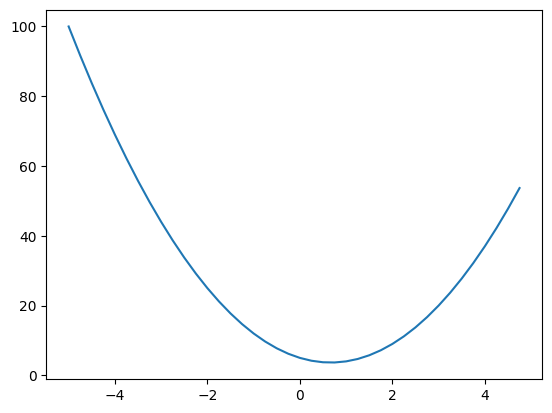

In [5]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (float, int)), "only supportinfg int and float"
        out = Value(self.data**other, (self,), label=f"**{other}")

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    def __sub__(self, other):
        return self + other*(-1)

    def __neg__(self):
        return self*(-1)
            
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()


In [7]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(2.0, label='f')
L = d*f; L.label='L'
L

Value(data=8.0)

In [8]:
a-b

Value(data=5.0)

In [9]:
d._op

'+'

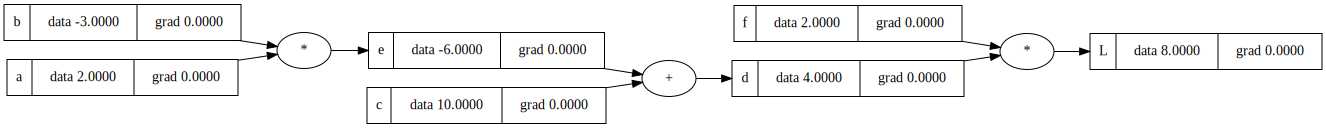

In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }"%(n.label, n.data, n.grad), shape='record')

        if(n._op):
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

draw_dot(L)

In [11]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813, label='b')

x1w1 = x1*w1
x1w1.label = "x1*w1"
x2w2 = x2*w2
x2w2.label = "x1*w1"

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2+b
n.label = "n"
o = n.tanh()
o.label = "o"
o.backward()

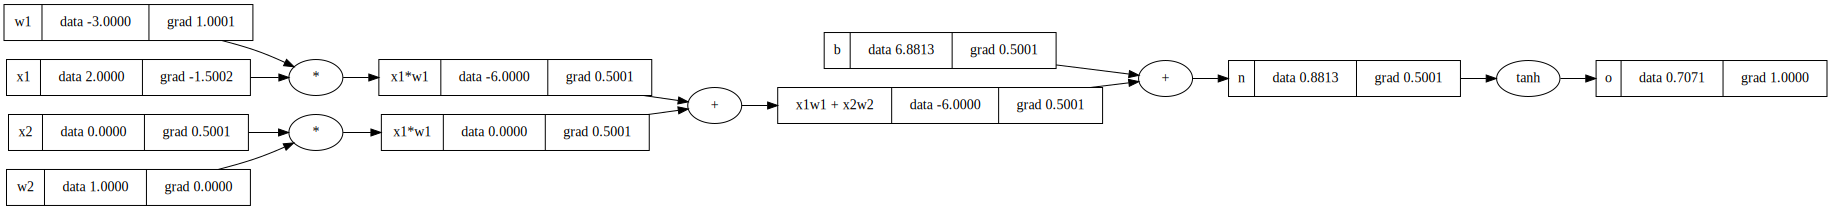

In [12]:
draw_dot(o)

In [13]:
a = Value(0.0)
a+1

Value(data=1.0)

In [14]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813, label='b')

x1w1 = x1*w1
x1w1.label = "x1*w1"
x2w2 = x2*w2
x2w2.label = "x1*w1"

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2+b
n.label = "n"
o = n.tanh()
o.label = "o"
o.backward()

In [19]:
import torch
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813]).double()
b.requires_grad = True
n = x1*w1+x2*w2+b
o = torch.tanh(n)

print(o.data.item())
o.backward()

0.7070699720278941


In [18]:
x1.grad.item()

AttributeError: 'NoneType' object has no attribute 'item'